# Custom implementation of *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

## Preprocessing

In [2]:
import numpy as np
import itertools
from qiskit import Aer, transpile, QuantumCircuit
from qiskit.circuit.library.standard_gates import RYGate

##### Input definition

In [3]:
def Generate_matrix(replicate_paper, matrix_dimension, eig_values_list=None):
    if replicate_paper == False:
        # Set dimension for the matrix
        random_matrix=np.random.rand(matrix_dimension, matrix_dimension) 
        hermitian_matrix=np.dot(random_matrix, random_matrix.T)

        eig, e_v = np.linalg.eig(hermitian_matrix)
        if eig_values_list is None:
            eig_values_list = np.array(eig)

        example_matrix = e_v @ np.diag(eig_values_list) @ e_v.T

    else:
        example_matrix = np.array([[1.5, 0.5],[0.5, 1.5]])

    print(f'Matrix:\n {example_matrix.round(2)}\n')
    for eigenval, eigenvec in zip(np.linalg.eig(example_matrix)[0][::-1], np.rot90(np.linalg.eig(example_matrix)[1])):
        print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(3)}')
    return example_matrix

In [4]:
#computing the thetas
def thetas_computation(example_matrix, debug = False):
    lst_combination=[]

    sum_squares = (example_matrix**2).sum()
    input_probabilities = (example_matrix**2/sum_squares).flatten()

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        if debug == True:
            print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

In [5]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

### Main

In [7]:
# Change this to false to generate a random matrix with choosen eigenvalues
replicate_paper = True 
example_matrix = Generate_matrix(replicate_paper,2,eig_values_list = np.array([2, 3]))

Matrix:
 [[ 3.14 -0.86 -0.29]
 [-0.86  3.13 -0.35]
 [-0.29 -0.35  2.72]]

eigenvalue: 3 - eigenvector: [-0.398 -0.347  0.849]
eigenvalue: 4 - eigenvector: [ 0.701 -0.712  0.037]
eigenvalue: 2 - eigenvector: [0.592 0.61  0.527]


as an example, we take the 2x2 matrix used in the original paper
$$
A_0=\left[\begin{array}{ll}
1.5 & 0.5 \\
0.5 & 1.5
\end{array}\right]
$$

whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

$20$ derives from $3^2 + 1^2 + 1^2 + 3^2$ and is necessary for normalization

0 -> 0.5651746979226692
1 -> 0.8249712484856788
00 -> 0.5631589143288079
01 -> 0.047691470767619655
10 -> 0.047691470767619655
11 -> 0.8235915762342649


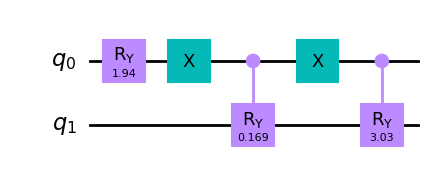

In [9]:
thetas, all_combinations = thetas_computation(example_matrix, debug = True)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw("mpl")

In [10]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

{'00': 0.317147962788002,
 '01': 0.002274476383979,
 '10': 0.002274476383979,
 '11': 0.678303084444041}